STEP 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)


STEP 2: Loading Dataset

In [4]:
df = pd.read_csv("/content/online_retail.csv", encoding="ISO-8859-1")

df.head()


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom

STEP 3: Understanding Dataset Structure

In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Dataset Understanding

The dataset consists of transactional data from an online retail business.
Each row represents a product-level transaction with details such as invoice number, product description, quantity purchased, price, customer ID, and country.
Missing values are primarily present in the CustomerID column, which is essential for customer-level analysis.

STEP 4: Data Cleaning & Preprocessing

In [9]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

In [10]:
# Remove cancelled invoices
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [11]:
# Remove invalid quantity & price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [12]:
# Convert date column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [13]:
# Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [14]:
# Final check
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalAmount    0
dtype: int64

In [15]:
df.shape

(397884, 9)

Data Preprocessing

Records with missing customer identifiers were removed as they are essential for customer segmentation.
Cancelled invoices were excluded to avoid negative impact on sales analysis.
Transactions with zero or negative quantity and price were filtered out.
A new feature, TotalAmount, was created to represent the monetary value of each transaction.

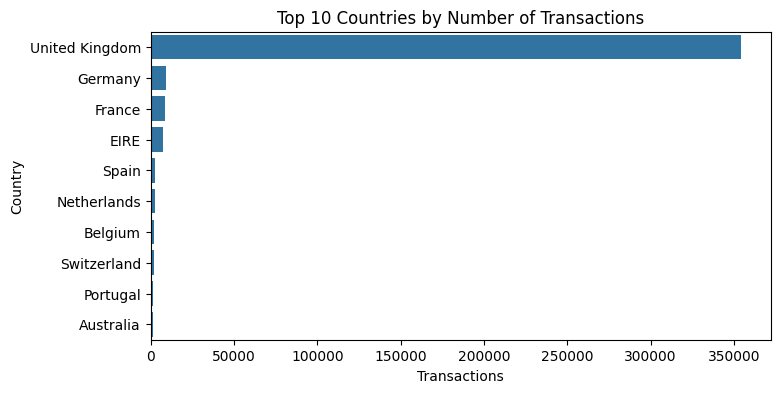

In [16]:
# Transactions by Country
top_countries = df['Country'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Transactions")
plt.ylabel("Country")
plt.show()

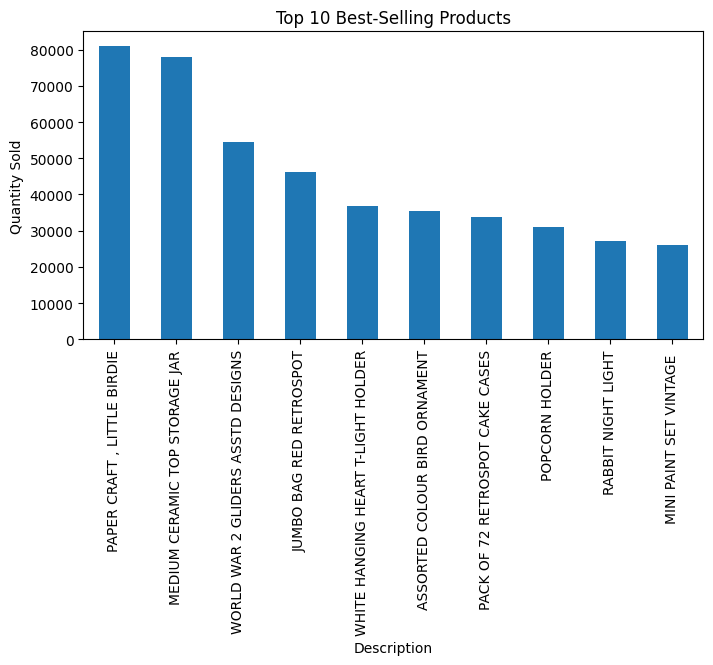

In [17]:
# Top Selling Products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
top_products.plot(kind='bar')
plt.title("Top 10 Best-Selling Products")
plt.ylabel("Quantity Sold")
plt.show()

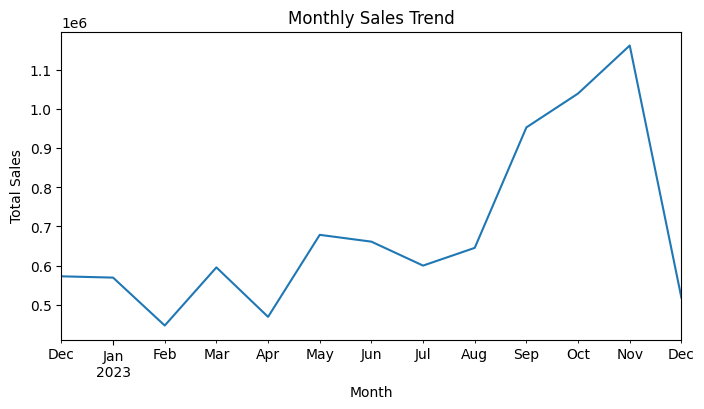

In [18]:
# Monthly Purchase Trend
df['Month'] = df['InvoiceDate'].dt.to_period('M')

monthly_sales = df.groupby('Month')['TotalAmount'].sum()

plt.figure(figsize=(8,4))
monthly_sales.plot()
plt.title("Monthly Sales Trend")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.show()

EDA shows that a small number of countries and products contribute significantly to total sales.
Sales trends vary across months, indicating seasonal purchasing behavior.
These insights can help businesses optimize inventory and marketing strategies.

STEP 6: RFM ANALYSIS

📌 Objective:
Convert transaction data into customer-level behavior metrics and segment customers using KMeans clustering.

In [19]:
# a. Define Snapshot Date
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2023-12-10 12:50:00')

In [20]:
# b. Create RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

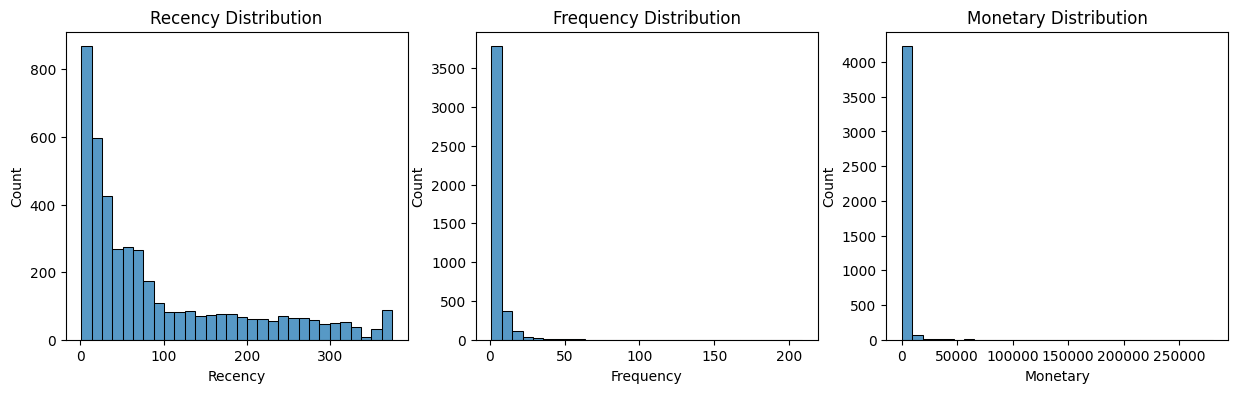

In [21]:
# c. Inspect RFM Distributions
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30)
plt.title("Recency Distribution")

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title("Frequency Distribution")

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title("Monetary Distribution")

plt.show()


In [22]:
# d. Standardize RFM Values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


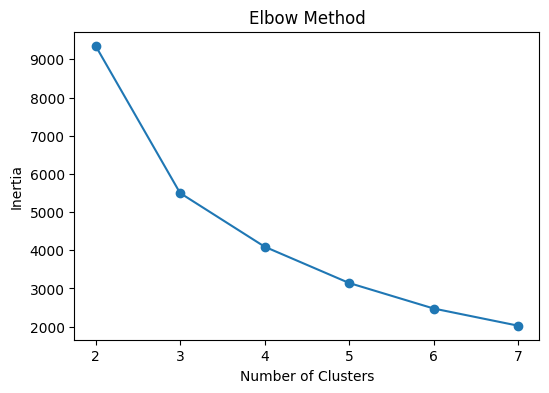

In [23]:
# e. Find Optimal Number of Clusters

# e.1 Elbow Method
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,8), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [24]:
# e.2 Silhouette Score
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"Clusters: {k}, Silhouette Score: {score:.3f}")

Clusters: 2, Silhouette Score: 0.560
Clusters: 3, Silhouette Score: 0.585
Clusters: 4, Silhouette Score: 0.616
Clusters: 5, Silhouette Score: 0.617
Clusters: 6, Silhouette Score: 0.598
Clusters: 7, Silhouette Score: 0.517


In [25]:
# f. Apply KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [26]:
# g. Interpret Clusters
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)


Recency  Frequency   Monetary
Cluster                               
0          43.70       3.68    1359.05
1         248.08       1.55     480.62
2           7.38      82.54  127338.31
3          15.50      22.33   12709.09

In [27]:
# h. Label Clusters
cluster_map = {
    0: "Regular",
    1: "High-Value",
    2: "Occasional",
    3: "At-Risk"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_map)
rfm.head()

CustomerID  Recency  Frequency  Monetary  Cluster     Segment
0     12346.0      326          1  77183.60        3     At-Risk
1     12347.0        2          7   4310.00        0     Regular
2     12348.0       75          4   1797.24        0     Regular
3     12349.0       19          1   1757.55        0     Regular
4     12350.0      310          1    334.40        1  High-Value

Customer Segmentation Insights

High-Value customers show low recency and high frequency and monetary value.
Regular customers purchase consistently but spend moderately.
Occasional customers make infrequent and low-value purchases.
At-Risk customers have not purchased recently and require retention strategies.

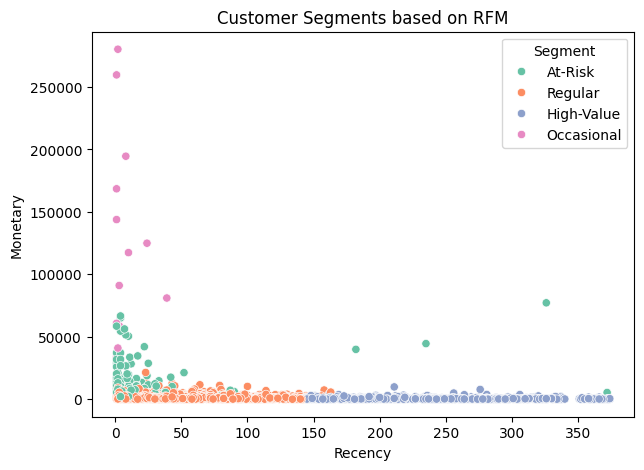

In [28]:
# h. Visualize Clusters
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=rfm['Recency'],
    y=rfm['Monetary'],
    hue=rfm['Segment'],
    palette='Set2'
)
plt.title("Customer Segments based on RFM")
plt.show()


In [29]:
# i. Save Models for Streamlit
import pickle

with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

STEP 7: PRODUCT RECOMMENDATION SYSTEM

Objective: Recommend 5 similar products based on historical purchase behavior using cosine similarity.

In [30]:
# a. Prepare Data for Recommendation
purchase_matrix = df.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

purchase_matrix.head()


Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
CustomerID                                                                    
12346.0                                   0                               0   
12347.0                                   0                               0   
12348.0                                   0                               0   
12349.0                                   0                               0   
12350.0                                   0                               0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
CustomerID                                                      
12346.0                       0                             0   
12347.0                       0                             0   
12348.0                       0                             0   
12349.0                       0                             0   
12350.0                       0                             0   

Description   I LOVE LONDON MINI RUCKSACK   NINE DRAWER OFFICE TIDY  \
CustomerID                                                            
12346.0                                 0                         0   
12347.0                                 0                         0   
12348.0                                 0                         0   
12349.0                                 0                         0   
12350.0                                 0                         0   

Description   OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
CustomerID                                                           
12346.0                                0                         0   
12347.0                                0                         0   
12348.0                                0                         0   
12349.0                                0                         0   
12350.0                                0                         0   

Description   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  \
CustomerID                                                               
12346.0                                     0                        0   
12347.0                                     0                        0   
12348.0                                     0                        0   
12349.0                                     0                        0   
12350.0                                     0                        0   

Description   TOADSTOOL BEDSIDE LIGHT    TRELLIS COAT RACK  \
CustomerID                                                   
12346.0                              0                   0   
12347.0                              0                   0   
12348.0                              0                   0   
12349.0                              0                   0   
12350.0                              0                   0   

Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
CustomerID                                                        
12346.0                           0                           0   
12347.0                           0                           0   
12348.0                           0                           0   
12349.0                           0                           0   
12350.0                           0                           0   

Description  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
CustomerID                                                          
12346.0                              0                          0   
12347.0                              0                          0   
12348.0                              0                          0   
12349.0                              0                          0   
12350.0                              0                          0   

Description  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
CustomerID    

Recommendation System Data Preparation:

A customer–product interaction matrix was created using purchase quantities.
Each row represents a customer, and each column represents a product.
This matrix serves as the foundation for item-based collaborative filtering.

In [31]:
# b. Transpose for Item-Based Filtering
product_matrix = purchase_matrix.T
product_matrix.head()

CustomerID                     12346.0  12347.0  12348.0  12349.0  12350.0  \
Description                                                                  
4 PURPLE FLOCK DINNER CANDLES        0        0        0        0        0   
50'S CHRISTMAS GIFT BAG LARGE        0        0        0        0        0   
DOLLY GIRL BEAKER                    0        0        0        0        0   
I LOVE LONDON MINI BACKPACK          0        0        0        0        0   
I LOVE LONDON MINI RUCKSACK          0        0        0        0        0   

CustomerID                     12352.0  12353.0  12354.0  12355.0  12356.0  \
Description                                                                  
4 PURPLE FLOCK DINNER CANDLES        0        0        0        0        0   
50'S CHRISTMAS GIFT BAG LARGE        0        0        0        0        0   
DOLLY GIRL BEAKER                    0        0        0        0        0   
I LOVE LONDON MINI BACKPACK          0        0        0        0        0   
I LOVE LONDON MINI RUCKSACK          0        0        0        0        0   

CustomerID                     12357.0  12358.0  12359.0  12360.0  12361.0  \
Description                                                                  
4 PURPLE FLOCK DINNER CANDLES        0        0        0        0        0   
50'S CHRISTMAS GIFT BAG LARGE        0        0        0        0        0   
DOLLY GIRL BEAKER                    0        0       12        0        0   
I LOVE LONDON MINI BACKPACK          0        0        4        0        0   
I LOVE LONDON MINI RUCKSACK          0        0        0        0        0   

CustomerID                     12362.0  12363.0  12364.0  12365.0  12367.0  \
Description                                                                  
4 PURPLE FLOCK DINNER CANDLES        0        0        0        0        0   
50'S CHRISTMAS GIFT BAG LARGE        0        0        0        0        0   
DOLLY GIRL BEAKER                   12        0        0        0        0   
I LOVE LONDON MINI BACKPACK          4        0        0        0        0   
I LOVE LONDON MINI RUCKSACK          0        0        0        0        0   

CustomerID                     12370.0  12371.0  12372.0  12373.0  12374.0  \
Description                                                                  
4 PURPLE FLOCK DINNER CANDLES        0        0        0        0        0   
50'S CHRISTMAS GIFT BAG LARGE        0        0        0        0        0   
DOLLY GIRL BEAKER                    0        0        0        0        0   
I LOVE LONDON MINI BACKPACK          0        0        0        0        0   
I LOVE LONDON MINI RUCKSACK          0        0        0        0        0   

CustomerID                     12375.0  12377.0  12378.0  12379.0  12380.0  \
Description                                                                  
4 PURPLE FLOCK DINNER CANDLES        0        0        0        0        0   
50'S CHRISTMAS GIFT BAG LARGE        0        0        0        0        0   
DOLLY GIRL BEAKER                    0        0        0        0        0   
I LOVE LONDON MINI BACKPACK          0        0        0        0        0   
I LOVE LONDON MINI RUCKSACK          0        0        0        0        0   

CustomerID                     12381.0  12383.0  12384.0  12386.0  12388.0  \
Description                                                                  
4 PURPLE FLOCK DINNER CANDLES        0        0        0        0        0   
50'S CHRISTMAS GIFT BAG LARGE        0        0        0        0        0   
DOLLY GIRL BEAKER                   12        0        0        0        0   
I LOVE LONDON MINI BACKPACK          0        0        0        0        0   
I LOVE LONDON MINI RUCKSACK          0        0        0        0        0   

CustomerID                     12390.0  12391.0  12393.0  12394.0  12395.0  \
Description                                                                  
4 PURPLE FLOCK 

In [32]:
# c. Compute Cosine Similarity
product_similarity = cosine_similarity(product_matrix)
product_similarity_df = pd.DataFrame(
    product_similarity,
    index=product_matrix.index,
    columns=product_matrix.index
)

product_similarity_df.iloc[:5, :5]

Description                    4 PURPLE FLOCK DINNER CANDLES  \
Description                                                    
4 PURPLE FLOCK DINNER CANDLES                       1.000000   
50'S CHRISTMAS GIFT BAG LARGE                       0.000000   
DOLLY GIRL BEAKER                                   0.000021   
I LOVE LONDON MINI BACKPACK                         0.000227   
I LOVE LONDON MINI RUCKSACK                         0.000000   

Description                    50'S CHRISTMAS GIFT BAG LARGE  \
Description                                                    
4 PURPLE FLOCK DINNER CANDLES                       0.000000   
50'S CHRISTMAS GIFT BAG LARGE                       1.000000   
DOLLY GIRL BEAKER                                   0.003533   
I LOVE LONDON MINI BACKPACK                         0.004001   
I LOVE LONDON MINI RUCKSACK                         0.000000   

Description                    DOLLY GIRL BEAKER  I LOVE LONDON MINI BACKPACK  \
Description                                                                     
4 PURPLE FLOCK DINNER CANDLES           0.000021                     0.000227   
50'S CHRISTMAS GIFT BAG LARGE           0.003533                     0.004001   
DOLLY GIRL BEAKER                       1.000000                     0.870851   
I LOVE LONDON MINI BACKPACK             0.870851                     1.000000   
I LOVE LONDON MINI RUCKSACK             0.980561                     0.883883   

Description                    I LOVE LONDON MINI RUCKSACK  
Description                                                 
4 PURPLE FLOCK DINNER CANDLES                     0.000000  
50'S CHRISTMAS GIFT BAG LARGE                     0.000000  
DOLLY GIRL BEAKER                                 0.980561  
I LOVE LONDON MINI BACKPACK                       0.883883  
I LOVE LONDON MINI RUCKSACK                       1.000000

Similarity Computation:

Cosine similarity was used to measure similarity between products based on customer purchase patterns.
Products with higher similarity scores indicate shared purchasing behavior among customers.

In [33]:
# d. Build Recommendation Function
def recommend_products(product_name, top_n=5):
    if product_name not in product_similarity_df.index:
        return "Product not found. Please check the name."

    similarity_scores = product_similarity_df[product_name]
    similar_products = similarity_scores.sort_values(ascending=False)[1:top_n+1]

    return list(similar_products.index)

In [34]:
# e. Test the Recommendation System
recommend_products("WHITE HANGING HEART T-LIGHT HOLDER")

['GIN + TONIC DIET METAL SIGN',
 'RED HANGING HEART T-LIGHT HOLDER',
 'WASHROOM METAL SIGN',
 'LAUNDRY 15C METAL SIGN',
 'GREEN VINTAGE SPOT BEAKER']

Recommendation Output Interpretation:

The system recommends products that are frequently purchased together by similar customers.
This approach enables personalized product suggestions and improves cross-selling opportunities.

In [35]:
# f. Save Similarity Matrix for Streamlit
with open("product_similarity.pkl", "wb") as f:
    pickle.dump(product_similarity_df, f)


In [36]:
from google.colab import files

files.download("kmeans_model.pkl")
files.download("scaler.pkl")
files.download("product_similarity.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>